v1.3

# Objective

- The objective of this **01.01** notebook is to 
  - clean the original text in the datasets
  - create pre- and post-cleaning text stats

# Pre-checks

In [1]:
## Check for Google Drive Connectivity
try:
    from google.colab import drive
    drive.mount('/content/drive')
    google_env = True
except:
    print("Not a Goolge Drive Environment.")
    google_env = False

Not a Goolge Drive Environment.


In [2]:
import time
t_start = time.time()

In [3]:
# Use parameters to enable/disable the fastrun

FASTRUN = False
#FASTRUN = True

# Size of the fastrun dataframe
sample_fraction = 0.1
print("==="*40)
print("Fastrun enabled:", FASTRUN)
if FASTRUN: print("Sample size:",sample_fraction)
print("==="*40)


Fastrun enabled: False


# Setup Environment

## Install Modules

In [4]:
#!pip install pandas --upgrade 
#!pip install watermark
#!pip install textstat
#!pip install nltk
#!pip install fasttext-langdetect

In [5]:
#import nltk
#nltk.download('popular')
#nltk.download('stopwords')

## Import Modules

In [6]:
# Base libraries
import os
import re
from datetime import date

# Scientific libraries
import numpy as np
import pandas as pd

# Specific libraries
import textstat
from ftlangdetect import detect
from nltk.corpus import stopwords

# Visualization
import seaborn as sns
sns.set(rc={'figure.figsize':(8,4)})
sns.set(font_scale=0.8)

# Helper libraries
from tqdm import tqdm
tqdm.pandas()
from watermark import watermark
import gc # garbage collection to optimize memory usage, use gc.collect()
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark

## Define Parameters

In [7]:
seed = 42
cpu_count = os.cpu_count()
cpu_count = cpu_count-2  # to keep machine responsive when fitting the models
notebook_no = "01.01"
today = date.today()

## Global Helper Functions

In [8]:
import http.client
import urllib


def send_push(message):
    """Send push notifications to pushover service."""
    try:
        conn = http.client.HTTPSConnection("api.pushover.net:443")
        conn.request("POST", "/1/messages.json",
                     urllib.parse.urlencode({
                         "token": "ahs1q4mwpnxe3645zeaqzas69whq7a",  # ML Notifications Channel
                         "user": "u5vr1qkc9ghudg2ehuug153okeiz1d",
                         "message": message,
                     }), {"Content-type": "application/x-www-form-urlencoded"})

        conn.getresponse()

    except:
        print("There was a communication issue (pushover).")


# 3.0 Load Data

https://www.kaggle.com/competitions/umich-siads-696-f22-predicting-text-difficulty/

In [9]:
# Load Data
if google_env:
    # Location for "shared with" people
    # create a shortcut of the shared folder in your Google Drive root folder
    ROOT_PATH = "/content/drive/MyDrive/SIADS696/Environment/"
else:
    ROOT_PATH = "../"
    print("Not a Google Drive Environment. Loading local files.")

PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_DATA_MOD = "models/"
PATH_DATA_REP = "reports/"
PATH_DATA_FIG = "reports/figures/"
PATH_DATA_HTML = "reports/html/"

df_wiki_train = pd.read_csv(ROOT_PATH+PATH_DATA_RAW+"WikiLarge_Train.csv")
df_wiki_test = pd.read_csv(ROOT_PATH+PATH_DATA_RAW+"WikiLarge_Test.csv")

Not a Google Drive Environment. Loading local files.


In [10]:
df_wiki_train.info()
df_wiki_train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416768 entries, 0 to 416767
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   original_text  416768 non-null  object
 1   label          416768 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


(416768, 2)

In [11]:
df_wiki_test.info()
df_wiki_test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119092 entries, 0 to 119091
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             119092 non-null  int64  
 1   original_text  119092 non-null  object 
 2   label          0 non-null       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB


(119092, 3)

# 4.0 Data Cleaning and Feature Engineering

**Tips on Creating Features**
- Linear models learn sums and differences naturally, but can't learn anything more complex.
- Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
- Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
- Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
- Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.
[Source](https://www.kaggle.com/code/ryanholbrook/creating-features)

## Pre-Cleaning Feature Construction (stats)

In [12]:
import textstat
textstat.set_lang('en')

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


def count_patterns(text, pattern):
    return len(re.findall(pattern, text))


def detect_lang(text):
    #https://pypi.org/project/fasttext-langdetect/
    result = detect(text, low_memory=False)['lang']
    return result

def detect_complete_sentence(text):
    # We assume that a complete sentence ends with a dot. The other samples are parsing errors.
    if text.startswith("Image : ")\
            or ("ISBN" in text)\
            or ("frac" in text)\
            or text.startswith("frac")\
            or text.startswith("m _")\
            or text.startswith("File :")\
            or text.startswith("-LRB- x ")\
            or text.startswith("Õ"):
        return 0
    
    elif text.endswith("."):  # sentence length will be check later with cleaned text
        return 1


def detect_image_desc(text):
    if text.startswith("Image : "):
        return 1
    else:
        return 0


def detect_frac_desc(text):
    if text.startswith("frac"):
        return 1
    else:
        return 0


def detect_file_desc(text):
    if text.startswith("File :"):
        return 1
    else:
        return 0


def detect_formula_desc(text):
    if text.startswith("m _"):
        return 1
    else:
        return 0


def pre_clean_calculate_text_stats(df):
    #df['stats_umlaut_count'] = df['original_text'].progress_apply(lambda x: count_patterns(x, "ü|ö|ä"))    # not really important
    #df['stats_numbers_count'] = df['original_text'].progress_apply(lambda x: count_patterns(x, "(\d+)"))   # not really important
    #df['stats_semicolon_count'] = df['original_text'].progress_apply(lambda x: count_patterns(x, ";"))     # not really important
    #df['stats_colon_count'] = df['original_text'].progress_apply(lambda x: count_patterns(x, ":"))         # not really important

    df['stats_lrb_count'] = df['original_text'].progress_apply(lambda x: count_patterns(x, "-LRB-"))
    df['stats_rrb_count'] = df['original_text'].progress_apply(lambda x: count_patterns(x, "-RRB-"))
    df['stats_comma_count'] = df['original_text'].progress_apply(lambda x: count_patterns(x, ","))
    df['stats_equalsign_count'] = df['original_text'].progress_apply(lambda x: count_patterns(x, "="))
    df['stats_char_count'] = df['original_text'].progress_apply(textstat.char_count)

    #df['stats_complete_sentence'] = df['original_text'].progress_apply(detect_complete_sentence)
    df['stats_image_description'] = df['original_text'].progress_apply(detect_image_desc)
    df['stats_frac_description'] = df['original_text'].progress_apply(detect_frac_desc)
    df['stats_file_description'] = df['original_text'].progress_apply(detect_file_desc)
    df['stats_formula_description'] = df['original_text'].progress_apply(detect_formula_desc)


    # Detect sentence language
    df['stats_language_code'] = df['original_text'].progress_apply(detect_lang)

    return df

In [14]:
%%time
df_wiki_train = pre_clean_calculate_text_stats(df_wiki_train)
df_wiki_test = pre_clean_calculate_text_stats(df_wiki_test)

100%|██████████| 119092/119092 [00:00<00:00, 150843.11it/s]

CPU times: user 7.5 s, sys: 187 ms, total: 7.69 s
Wall time: 7.71 s


In [17]:
#df_wiki_train['stats_language'].value_counts()
df_wiki_train['stats_language_code'].nunique()

90

In [18]:
#df_wiki_test['stats_language'].value_counts()
df_wiki_test['stats_language_code'].nunique()

60

## Text Cleaning

In [19]:
def clean_text(text):
    text = text.lower()
    
    text = text.replace("ü","ue")
    text = text.replace("ä","ae")
    text = text.replace("ö","oe")
    text = text.replace("ß","ss")
    text = text.replace("é","e")
    text = text.replace("è","e")
    text = text.replace("ê","e")

    text = text.replace("-lrb-"," ")
    text = text.replace("-rrb-"," ")
    text = text.replace("/o"," ")
    text = text.replace("/"," ")

    text = text.replace("i , ii , iii , iv , v , vi , vii , viii , ix , and x."," ")

    text = re.sub("\s[']\w\s", " ", text)  # to remove the single "'x", eg.: "She 's"

    text = text.replace("-lsb-"," ")
    text = text.replace("-rsb-"," ")
    text = text.replace("-lcb-"," ")
    text = text.replace("-rcb-"," ")
    text = text.replace("frac"," ")

    # for easier cleaning and to keep the separation between two-words: two words
    text = text.replace("-"," - ")

    # Change did n't to didnt
    text = text.replace(" n't","nt")
    
    pattern = r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"
    text = re.sub(pattern, " ", text)

    # Remove unicode
    text = text.encode("ascii", "ignore")
    text = text.decode()

    text = re.sub("\s\s+", " ", text)  # to replace trailig whitespace with a single space
    text = text.strip()
    
    return text


def clean_df(df):
    try:
        df.insert(1, "cleaned_text", "")
    except:
        print("Already added.")
    df['cleaned_text'] = df['original_text'].apply(clean_text)

    return df

In [20]:
%%time
df_wiki_train = clean_df(df_wiki_train)
df_wiki_test = clean_df(df_wiki_test)

CPU times: user 7.57 s, sys: 111 ms, total: 7.68 s
Wall time: 7.7 s


In [21]:
## This did not improve the RF score:

# Correct incorrect language detection
len(df_wiki_train[(df_wiki_train['stats_language_code'] != 'en')])

#english_common_words = ["the", "you", "that", "was", "there", "term", "there are", "about"]
english_common_words = ["the"]

for word in english_common_words: 
    df_wiki_train['stats_language_code'] = np.where(
                                        df_wiki_train['cleaned_text'].str.contains(word), "en", 
                                        df_wiki_train['stats_language_code'])

len(df_wiki_train[(df_wiki_train['stats_language_code'] != 'en')])

7940

7524

In [22]:
## This did not improve the RF score:

len(df_wiki_test[(df_wiki_test['stats_language_code'] != 'en')])

for word in english_common_words: 
    df_wiki_test['stats_language_code'] = np.where(
                                        df_wiki_test['cleaned_text'].str.contains(word), "en", 
                                        df_wiki_test['stats_language_code'])

len(df_wiki_test[(df_wiki_test['stats_language_code'] != 'en')])

2147

2032

In [23]:
df_wiki_train.sample(4).T

,30036,359976,332752,50885
original_text,They reassured him that they were not one of the battalions looking for revenge .,The album went triple platinum in the United States .,"In December 1982 , the recently elected Chancellor Helmut Kohl deliberately lost a motion of confidence in order to hold new general elections .",2015 -LRB- MMXV -RRB- will be a common year starting on Thursday of the Gregorian calendar .
cleaned_text,they reassured him that they were not one of the battalions looking for revenge,the album went triple platinum in the united states,in december 1982 the recently elected chancellor helmut kohl deliberately lost a motion of confidence in order to hold new general elections,2015 mmxv will be a common year starting on thursday of the gregorian calendar
label,1,0,0,1
stats_lrb_count,0,0,0,1
stats_rrb_count,0,0,0,1
stats_comma_count,0,0,1,0
stats_equalsign_count,0,0,0,0
stats_char_count,67,44,121,76
stats_image_description,0,0,0,0
stats_frac_description,0,0,0,0


In [24]:
df_wiki_test.sample(4).T

,880,13280,74436,98285
id,880,13280,74436,98285
cleaned_text,,at the start of his ministry jesus was baptized by john the baptist,plushenko is known for his consistency and his strong jumping ability,the new feature is often promoted on the cbbc channel
original_text,",","At the start of his ministry , Jesus was baptized by John the Baptist .",Plushenko is known for his consistency and his strong jumping ability .,The new feature is often promoted on the CBBC Channel .
label,NaN,NaN,NaN,NaN
stats_lrb_count,0,0,0,0
stats_rrb_count,0,0,0,0
stats_comma_count,1,1,0,0
stats_equalsign_count,0,0,0,0
stats_char_count,1,57,60,45
stats_image_description,0,0,0,0


## Post-Cleaning Feature Construction (stats_)

In [25]:
def count_words(text):
    return len(text.split())


def count_long_numbers(text):
    counter = 0
    word_list = text.split()
    for word in word_list:
        if word.isnumeric() and len(word) > 4:
            counter += 1
    return counter


def count_long_word(text):
    counter = 0
    word_list = text.split()
    for word in word_list:
        if len(word) >= 15 and not word.isnumeric():
            counter += 1
    return counter


def count_mini_words(text):
    counter = 0
    word_list = text.split()
    for word in word_list:
        if len(word) <= 3 and not word.isnumeric():
            counter += 1
    return counter


def lexical_diversity(text):
    text = text.split()
    #print(len(text))
    #print(len(set(text)))
    if len(text) > 0:
        #print(text)
        result = len(set(text)) / len(text)
        return result
    else:
        return -1


def unusual_words_count(text_vocab, english_vocab):
    """Counts uncommon or mis-spelt words."""
    unusual = text_vocab.difference(english_vocab)
    #print(len(text_vocab))
    #print(len(unusual))
    return len(unusual)


def create_text_vocab(text):
    text = text.split()
    text_vocab = set(w for w in text if w.isalpha())
    return text_vocab


def count_stopwords(text):
    text = text.split()
    nltk_stopwords = (nltk.corpus.stopwords.words('english'))
    stopwords_list = [w for w in text if w.lower() not in nltk_stopwords]
    return len(stopwords_list)


def content_fraction(text):
    """Computes what fraction of words in a text are not in the stopwords list."""
    text = text.split()
    nltk_stopwords = nltk.corpus.stopwords.words('english')
    stopwords_list = [w for w in text if w.lower() not in nltk_stopwords]
    if len(text) > 0:  # TODO: Check why we have 0 text content
        #print(text)
        result = len(stopwords_list) / len(text)
        print(result)
        return result  # reduce the range for tree-based classifiers
    else:
        return -1


def max_char(text):
    text = text.split()
    if len(text) > 0:
        text = [len(w) for w in text]
        return np.array(text).max()
    else:
        return -1


def mean_char(text):
    text = text.split()
    if len(text) > 0:
        text = [len(w) for w in text]
        return np.array(text).mean()    # .round(1)
    else:
        return -1


def max_syllables(text):
    text = text.split()
    if len(text) > 0:
        text = [textstat.syllable_count(w) for w in text]
        return np.array(text).max()
    else:
        return -1


def mean_syllables(text):
    text = text.split()
    if len(text) > 0:
        text = [textstat.syllable_count(w) for w in text]
        return np.array(text).mean()    #.round(1)
    else:
        return -1

In [26]:
# Textstats
lang = "en"
#english_vocab = set(w for w in nltk.corpus.words.words())

def calculate_text_stats(df):
    print("Calculate stats_word_count")
    df['stats_avg_char_per_word'] = df['cleaned_text'].progress_apply(textstat.avg_character_per_word)  #.round(1)
    df['stats_word_count'] = df['cleaned_text'].progress_apply(textstat.lexicon_count)

    print("Calculate stats_letter_count")
    df['stats_letter_count'] = df['cleaned_text'].progress_apply(textstat.letter_count)

    print("Calculate stats_long_word_count")
    df['stats_long_word_count'] = df['cleaned_text'].progress_apply(textstat.long_word_count)
    
    print("Calculate stats_syllable_count")
    df['stats_syllable_count'] = df['cleaned_text'].progress_apply(textstat.syllable_count)
    df['stats_syllable_count'] = df['stats_syllable_count'].fillna(0)  # to address 0 syllables
    
    print("Calculate stats_polysyllab_count")
    df['stats_polysyllab_count'] = df['cleaned_text'].progress_apply(textstat.polysyllabcount)
    df['stats_polysyllab_count'] = df['stats_polysyllab_count'].fillna(0)  # to address 0 syllables
    
    print("Calculate stats_monosyllab_count")
    df['stats_monosyllab_count'] = df['cleaned_text'].progress_apply(textstat.monosyllabcount)
    df['stats_monosyllab_count'] = df['stats_monosyllab_count'].fillna(0)  # to address 0 syllables
    
    print("Calculate stats_reading_time")
    df['stats_reading_time'] = df['cleaned_text'].progress_apply(lambda x: textstat.reading_time(x, ms_per_char=14.69)) #.round(1)
    df['stats_reading_time'] = df['stats_reading_time'].fillna(-1)  # to address 0 syllables

    print("Calculate stats_avg_letter_per_word")
    df['stats_avg_letter_per_word'] = df['cleaned_text'].progress_apply(textstat.avg_letter_per_word) #.round(1)
    
    print("Calculate stats_sentence_length")
    df['stats_sentence_length'] = df['cleaned_text'].progress_apply(textstat.avg_sentence_length) # .round(1)
    
    print("Calculate stats_syllable_avg")
    df['stats_syllable_avg'] = df['cleaned_text'].progress_apply(textstat.avg_syllables_per_word) # .round(1)
    df['stats_syllable_avg'] = df['stats_syllable_avg'].fillna(0)  # to address 0 syllables

    print("Calculate stats_mini_word_count")
    df['stats_mini_word_count'] = df['cleaned_text'].progress_apply(count_mini_words)

    print("Calculate stats_long_numbers_count")
    df['stats_long_numbers_count'] = df['cleaned_text'].progress_apply(count_long_numbers)

    print("Calculate stats_lexical_diversity")
    df['stats_lexical_diversity'] = df['cleaned_text'].progress_apply(lexical_diversity)
    
    df['stats_frac_word_comma'] = (df['stats_comma_count'] / df['stats_word_count']) # .round(1)
    df['stats_frac_word_comma'] = df['stats_frac_word_comma'].fillna(0)
    df['stats_frac_word_comma'] = df['stats_frac_word_comma'].replace([np.inf, -np.inf], 0)

    df['stats_frac_mini_word'] = (df['stats_mini_word_count'] / df['stats_word_count']) # .round(1)
    df['stats_frac_mini_word'] = df['stats_frac_mini_word'].fillna(0)
    df['stats_frac_mini_word'] = df['stats_frac_mini_word'].replace([np.inf, -np.inf], 0)

    df['stats_frac_long_word'] = (df['stats_long_word_count'] / df['stats_word_count']) # .round(1)
    df['stats_frac_long_word'] = df['stats_frac_long_word'].fillna(0)
    df['stats_frac_long_word'] = df['stats_frac_long_word'].replace([np.inf, -np.inf], 0)

    df['stats_frac_monosyllable'] = (df['stats_monosyllab_count'] / df['stats_word_count']) # .round(1)
    df['stats_frac_monosyllable'] = df['stats_frac_monosyllable'].fillna(0)
    df['stats_frac_monosyllable'] = df['stats_frac_monosyllable'].replace([np.inf, -np.inf], 0)

    df['stats_frac_polysyllable'] = (df['stats_polysyllab_count'] / df['stats_word_count']) # .round(1)
    df['stats_frac_polysyllable'] = df['stats_frac_polysyllable'].fillna(0)
    df['stats_frac_polysyllable'] = df['stats_frac_polysyllable'].replace([np.inf, -np.inf], 0)

    df.fillna(-1, inplace=True)  # replace any remaining NaN

    return df

In [27]:
def calculate_additional_text_stats(df):
    print("Calculate additional stats")
    df['stats_max_chars_word'] = df['cleaned_text'].progress_apply(max_char)
    df['stats_avg_chars_word'] = df['cleaned_text'].progress_apply(mean_char)
    df['stats_max_syllables_word'] = df['cleaned_text'].progress_apply(max_syllables)
    df['stats_avg_syllables_word'] = df['cleaned_text'].progress_apply(mean_syllables)
    return df


In [28]:
%%time
df_wiki_train = calculate_text_stats(df_wiki_train)
df_wiki_train = calculate_additional_text_stats(df_wiki_train)

Calculate stats_word_count


100%|██████████| 416768/416768 [00:00<00:00, 503514.62it/s]


Calculate stats_letter_count


100%|██████████| 416768/416768 [00:00<00:00, 511761.74it/s]


Calculate stats_long_word_count


100%|██████████| 416768/416768 [00:01<00:00, 372857.96it/s]


Calculate stats_syllable_count


100%|██████████| 416768/416768 [00:06<00:00, 60140.72it/s]


Calculate stats_polysyllab_count


100%|██████████| 416768/416768 [00:06<00:00, 62644.33it/s]


Calculate stats_monosyllab_count


100%|██████████| 416768/416768 [00:07<00:00, 58966.11it/s]


Calculate stats_reading_time


100%|██████████| 416768/416768 [00:01<00:00, 330435.18it/s]


Calculate stats_avg_letter_per_word


100%|██████████| 416768/416768 [00:01<00:00, 254117.65it/s]


Calculate stats_sentence_length


100%|██████████| 416768/416768 [00:02<00:00, 198922.08it/s]


Calculate stats_syllable_avg


100%|██████████| 416768/416768 [00:06<00:00, 65782.47it/s]


Calculate stats_mini_word_count


100%|██████████| 416768/416768 [00:00<00:00, 529246.42it/s]


Calculate stats_long_numbers_count


100%|██████████| 416768/416768 [00:00<00:00, 651955.71it/s]


Calculate stats_lexical_diversity


100%|██████████| 416768/416768 [00:00<00:00, 537962.86it/s]


Calculate additional stats


100%|██████████| 416768/416768 [00:08<00:00, 48557.55it/s]

CPU times: user 57.7 s, sys: 942 ms, total: 58.6 s
Wall time: 58.6 s


In [29]:
%%time
df_wiki_test = calculate_text_stats(df_wiki_test)
df_wiki_test = calculate_additional_text_stats(df_wiki_test)

Calculate stats_word_count


100%|██████████| 119092/119092 [00:00<00:00, 508249.43it/s]


Calculate stats_letter_count


100%|██████████| 119092/119092 [00:00<00:00, 549124.77it/s]


Calculate stats_long_word_count


100%|██████████| 119092/119092 [00:00<00:00, 389387.97it/s]


Calculate stats_syllable_count


100%|██████████| 119092/119092 [00:01<00:00, 71768.11it/s]


Calculate stats_polysyllab_count


100%|██████████| 119092/119092 [00:01<00:00, 85891.75it/s]


Calculate stats_monosyllab_count


100%|██████████| 119092/119092 [00:01<00:00, 77890.04it/s]


Calculate stats_reading_time


100%|██████████| 119092/119092 [00:00<00:00, 350209.04it/s]


Calculate stats_avg_letter_per_word


100%|██████████| 119092/119092 [00:00<00:00, 266518.72it/s]


Calculate stats_sentence_length


100%|██████████| 119092/119092 [00:00<00:00, 212982.95it/s]


Calculate stats_syllable_avg


100%|██████████| 119092/119092 [00:01<00:00, 72261.09it/s]


Calculate stats_mini_word_count


100%|██████████| 119092/119092 [00:00<00:00, 531869.66it/s]


Calculate stats_long_numbers_count


100%|██████████| 119092/119092 [00:00<00:00, 648443.96it/s]


Calculate stats_lexical_diversity


100%|██████████| 119092/119092 [00:00<00:00, 540656.32it/s]


Calculate additional stats


100%|██████████| 119092/119092 [00:01<00:00, 62666.77it/s]

CPU times: user 13.9 s, sys: 254 ms, total: 14.2 s
Wall time: 14.2 s


In [33]:
df_wiki_train['stats_language_no'] = le.fit_transform(df_wiki_train['stats_language_code'])
df_wiki_test['stats_language_no'] = le.fit_transform(df_wiki_test['stats_language_code'])

In [30]:
# Update complete sentence stats:
# len(df_wiki_train[(df_wiki_train['stats_complete_sentence'] == 1)])

# df_wiki_train['stats_complete_sentence'] = np.where(
#                                     (df_wiki_train['stats_complete_sentence'] == 1) & (df_wiki_train['stats_word_count'] > 4), 1, 0)

# len(df_wiki_train[(df_wiki_train['stats_complete_sentence'] == 1)])

In [31]:
# Update complete sentence stats:
# len(df_wiki_test[(df_wiki_test['stats_complete_sentence'] == 1)])

# df_wiki_test['stats_complete_sentence'] = np.where(
#                                     (df_wiki_test['stats_complete_sentence'] == 1) & (df_wiki_test['stats_word_count'] > 4), 1, 0)

# len(df_wiki_test[(df_wiki_test['stats_complete_sentence'] == 1)])

In [32]:
#df_wiki_train[(df_wiki_train['stats_complete_sentence'] == 1)].sample(10)

In [34]:
#df_wiki_train = df_wiki_train.fillna(-1)
#df_wiki_test = df_wiki_test.fillna(-1)

In [35]:
#df_wiki_train.sample(4).T

In [36]:
#df_wiki_test.sample(4).T

# 5.0 Export

In [39]:
# Export STATS features
feature_columns = df_wiki_train.columns.to_list()

df_export = df_wiki_train
df_export.to_pickle(ROOT_PATH+PATH_DATA_INT + "train_features_clean_stats.pkl")
df_export.to_parquet(ROOT_PATH+PATH_DATA_INT + 'train_features_clean_stats.parquet.gzip', compression='gzip')

print("features created:", len(feature_columns)-3)
print(sorted(feature_columns))

features created: 34
['cleaned_text', 'label', 'original_text', 'stats_avg_char_per_word', 'stats_avg_chars_word', 'stats_avg_letter_per_word', 'stats_avg_syllables_word', 'stats_char_count', 'stats_comma_count', 'stats_equalsign_count', 'stats_file_description', 'stats_formula_description', 'stats_frac_description', 'stats_frac_long_word', 'stats_frac_mini_word', 'stats_frac_monosyllable', 'stats_frac_polysyllable', 'stats_frac_word_comma', 'stats_image_description', 'stats_language_code', 'stats_language_no', 'stats_letter_count', 'stats_lexical_diversity', 'stats_long_numbers_count', 'stats_long_word_count', 'stats_lrb_count', 'stats_max_chars_word', 'stats_max_syllables_word', 'stats_mini_word_count', 'stats_monosyllab_count', 'stats_polysyllab_count', 'stats_reading_time', 'stats_rrb_count', 'stats_sentence_length', 'stats_syllable_avg', 'stats_syllable_count', 'stats_word_count']


In [40]:
df_export = df_wiki_test
df_export.to_pickle(ROOT_PATH+PATH_DATA_INT+"test_features_clean_stats.pkl")
df_export.to_parquet(ROOT_PATH+PATH_DATA_INT + 'test_features_clean_stats.parquet.gzip', compression='gzip')

# 6.0 Initial EDA

In [41]:
len(df_wiki_train[df_wiki_train['stats_word_count'] < 4])
df_wiki_train[df_wiki_train['stats_word_count'] == 0].head()

23410

,original_text,cleaned_text,label,stats_lrb_count,stats_rrb_count,stats_comma_count,stats_equalsign_count,stats_char_count,stats_image_description,stats_frac_description,stats_file_description,stats_formula_description,stats_language_code,stats_avg_char_per_word,stats_word_count,stats_letter_count,stats_long_word_count,stats_syllable_count,stats_polysyllab_count,stats_monosyllab_count,stats_reading_time,stats_avg_letter_per_word,stats_sentence_length,stats_syllable_avg,stats_mini_word_count,stats_long_numbers_count,stats_lexical_diversity,stats_frac_word_comma,stats_frac_mini_word,stats_frac_long_word,stats_frac_monosyllable,stats_frac_polysyllable,stats_max_chars_word,stats_avg_chars_word,stats_max_syllables_word,stats_avg_syllables_word,stats_language_no
607,! '',,1,0,0,0,0,3,0,0,0,0,oc,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,-1.0,0.0,0.0,0.0,0.0,0.0,-1,-1.0,-1,-1.0,61
1913,-- -RRB-,,1,0,1,0,0,7,0,0,0,0,zh,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,-1.0,0.0,0.0,0.0,0.0,0.0,-1,-1.0,-1,-1.0,88
2010,-- -RRB-,,1,0,1,0,0,7,0,0,0,0,zh,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,-1.0,0.0,0.0,0.0,0.0,0.0,-1,-1.0,-1,-1.0,88
2118,.,,1,0,0,0,0,1,0,0,0,0,fr,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,-1.0,0.0,0.0,0.0,0.0,0.0,-1,-1.0,-1,-1.0,25
3821,.,,1,0,0,0,0,1,0,0,0,0,fr,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,-1.0,0.0,0.0,0.0,0.0,0.0,-1,-1.0,-1,-1.0,25


In [42]:
# Balance Check
df_wiki_train['label'].value_counts()

1    208384
0    208384
Name: label, dtype: int64

## Checking Text Statistics

In [43]:
df_wiki_train.describe(exclude='object').T.style.set_properties(**{'text-align': 'center'}).format(
    {
        'mean': '{:,.2f}',
    },
).set_caption('Text Statistics for WikiTrain<br><br>')


,count,mean,std,min,25%,50%,75%,max
label,416768.000000,0.50,0.500001,0.000000,0.000000,0.500000,1.000000,1.000000
stats_lrb_count,416768.000000,0.26,0.583537,0.000000,0.000000,0.000000,0.000000,17.000000
stats_rrb_count,416768.000000,0.26,0.585145,0.000000,0.000000,0.000000,0.000000,17.000000
stats_comma_count,416768.000000,1.17,1.530944,0.000000,0.000000,1.000000,2.000000,32.000000
stats_equalsign_count,416768.000000,0.01,0.113439,0.000000,0.000000,0.000000,0.000000,18.000000
stats_char_count,416768.000000,96.95,57.716588,1.000000,56.000000,87.000000,128.000000,520.000000
stats_image_description,416768.000000,0.00,0.021846,0.000000,0.000000,0.000000,0.000000,1.000000
stats_frac_description,416768.000000,0.00,0.005137,0.000000,0.000000,0.000000,0.000000,1.000000
stats_file_description,416768.000000,0.00,0.008484,0.000000,0.000000,0.000000,0.000000,1.000000
stats_formula_description,416768.000000,0.00,0.004098,0.000000,0.000000,0.000000,0.000000,1.000000


In [44]:
df_wiki_test.describe(exclude='object').T.style.set_properties(**{'text-align': 'center'}).format(
    {
        'mean': '{:,.2f}',
    },
).set_caption('Text Statistics for WikiTest<br><br>')

,count,mean,std,min,25%,50%,75%,max
id,119092.000000,"59,545.50",34379.043466,0.000000,29772.750000,59545.500000,89318.250000,119091.000000
label,119092.000000,-1.00,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
stats_lrb_count,119092.000000,0.26,0.581187,0.000000,0.000000,0.000000,0.000000,13.000000
stats_rrb_count,119092.000000,0.26,0.583570,0.000000,0.000000,0.000000,0.000000,13.000000
stats_comma_count,119092.000000,1.18,1.539576,0.000000,0.000000,1.000000,2.000000,27.000000
stats_equalsign_count,119092.000000,0.00,0.102372,0.000000,0.000000,0.000000,0.000000,9.000000
stats_char_count,119092.000000,97.08,57.555279,1.000000,57.000000,87.000000,128.000000,437.000000
stats_image_description,119092.000000,0.00,0.020072,0.000000,0.000000,0.000000,0.000000,1.000000
stats_frac_description,119092.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
stats_file_description,119092.000000,0.00,0.007098,0.000000,0.000000,0.000000,0.000000,1.000000


## Languages Detected (with all samples)

In [45]:
df_wiki_train['stats_language_code'].unique()
len(df_wiki_train['stats_language_code'].unique())
print("---"*30)
df_wiki_test['stats_language_code'].unique()
len(df_wiki_test['stats_language_code'].unique())

array(['en', 'de', 'tt', 'fr', 'ja', 'es', 'hr', 'oc', 'no', 'nl', 'ms',
       'sv', 'it', 'zh', 'id', 'tl', 'eu', 'ro', 'ia', 'kn', 'fa', 'sr',
       'vi', 'cy', 'ur', 'pt', 'tr', 'io', 'jbo', 'war', 'el', 'fi', 'lb',
       'eo', 'ca', 'ru', 'la', 'hi', 'ceb', 'sl', 'da', 'mk', 'uk', 'cs',
       'sk', 'km', 'az', 'lt', 'ilo', 'pl', 'fy', 'th', 'nds', 'gu', 'bs',
       'gl', 'su', 'br', 'hu', 'uz', 'pms', 'ce', 'ml', 'ne', 'nn', 'ar',
       'vo', 'bn', 'te', 'bcl', 'et', 'hsb', 'si', 'als', 'ky', 'sh',
       'sco', 'is', 'ga', 'ta', 'kk', 'hy', 'sq', 'ast', 'ko', 'bar',
       'ie', 'lv', 'af'], dtype=object)

89

------------------------------------------------------------------------------------------


array(['fr', 'en', 'it', 'sv', 'es', 'ceb', 'de', 'ca', 'sr', 'pt', 'eo',
       'zh', 'pl', 'ja', 'oc', 'ru', 'fi', 'fa', 'nl', 'tr', 'ro', 'nn',
       'no', 'da', 'sl', 'la', 'lb', 'bcl', 'io', 'ne', 'bn', 'hu', 'eu',
       'ms', 'hr', 'kn', 'si', 'id', 'et', 'war', 'cy', 'th', 'hi', 'ta',
       'ba', 'mk', 'sw', 'uk', 'gl', 'cs', 'tt', 'tl', 'ur', 'az', 'lv',
       'gu', 'sh', 'als', 'bs', 'nds'], dtype=object)

60

In [46]:
df_wiki_train['stats_language_code'].value_counts()

en     409244
fr       2491
de       1274
es        736
it        424
pt        330
zh        327
nl        214
ru        168
ja        130
sv        128
ca         98
sr         84
pl         84
ceb        78
no         63
tr         59
fi         57
hr         50
la         47
id         44
eo         43
eu         39
ro         35
ms         34
cs         32
uk         32
io         31
war        30
da         29
hu         25
vi         23
sl         22
hi         19
th         18
mk         13
gl         13
et         13
sk         13
fa         10
ur          8
tt          8
ar          8
lb          7
tl          7
si          7
oc          7
ta          6
lt          6
kn          6
gu          6
sh          5
el          5
als         4
bn          4
nn          4
nds         4
fy          4
az          3
bs          3
jbo         3
is          3
ml          3
br          3
sq          3
ilo         2
ga          2
cy          2
km          2
ie          2
te          2
vo    

In [47]:
df_filtered = df_wiki_train[df_wiki_train['stats_language_code'] != 'en']

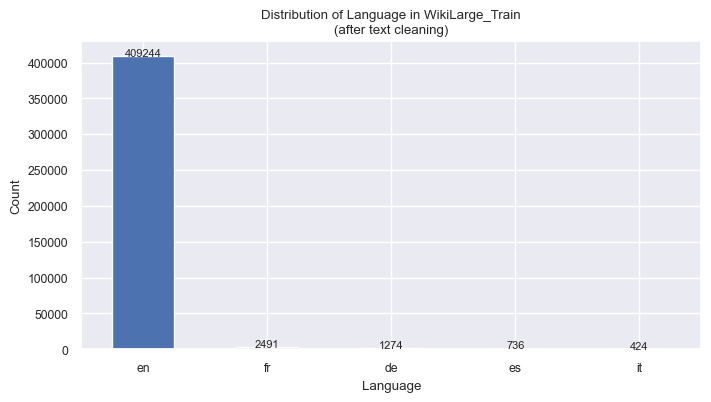

In [48]:
import matplotlib.pyplot as plt

# Plot the bar chart
counts = df_wiki_train['stats_language_code'].value_counts().head(5)
ax = counts.plot(kind="bar")

# Add labels
plt.title("Distribution of Language in WikiLarge_Train\n(after text cleaning)")
plt.xlabel("Language")
plt.ylabel("Count")

# Rotate x-tick labels
plt.xticks(rotation=0)

# Add values to the bars
for i, count in enumerate(counts):
    ax.text(i, count + 0.1, str(count), ha='center', fontsize=8)

# Display the plot
plt.show();


## Checking for complete sentences

In [49]:
# Check non-English sentences which are also flagged as completed to see the quality of the detection
#df_wiki_train[(df_wiki_train['stats_complete_sentence'] == 1) & (df_wiki_train['stats_language_code'] != 'en')].sample(10)

- Result: A lot of false negatives. We need to "overwrite" the language-detect decision.
- Approach: Looking for the most common English words in the sentence, such as "the", "you", "that": https://www.espressoenglish.net/the-100-most-common-words-in-english/

## Checking Distribution of Sentence Length (stats_word_count)

### Looking at the Distribution

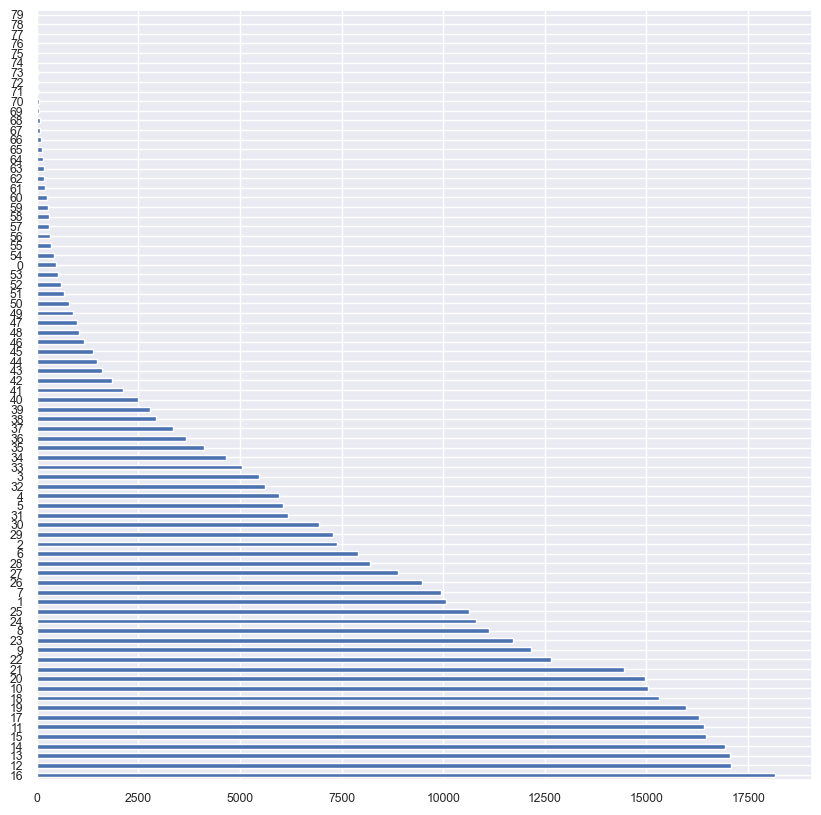

In [50]:
df_wiki_train['stats_word_count'].value_counts().plot(kind='barh', figsize=(10,10));

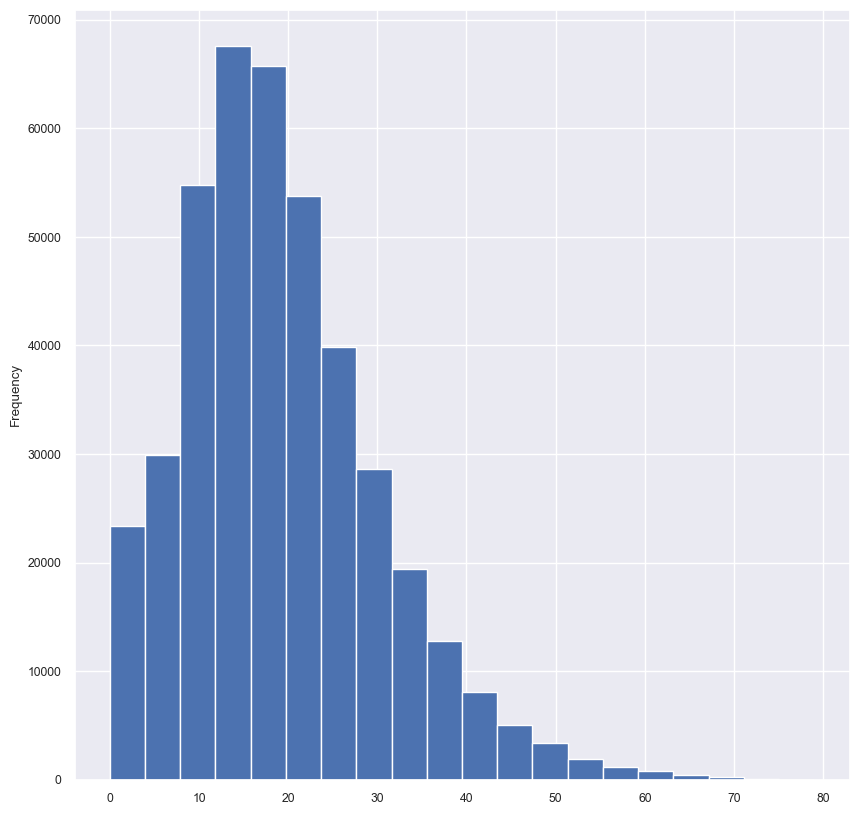

In [51]:
df_wiki_train['stats_word_count'].plot(kind='hist', figsize=(10,10), bins=20);

In [52]:
len(df_wiki_train.query('stats_word_count < 5'))

29375

In [53]:
df_filtered = df_wiki_train[df_wiki_train['stats_word_count'] < 6]

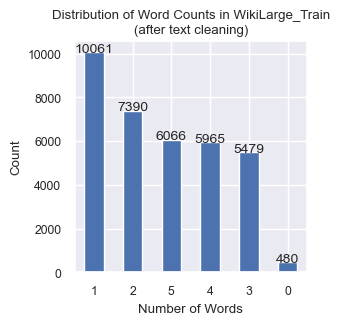

In [68]:
import matplotlib.pyplot as plt

# Plot the bar chart
counts = df_filtered['stats_word_count'].value_counts()
ax = counts.plot(kind="bar", figsize=(3,3))

# Add labels
plt.title("Distribution of Word Counts in WikiLarge_Train\n(after text cleaning)")
plt.xlabel("Number of Words")
plt.ylabel("Count")

# Rotate x-tick labels
plt.xticks(rotation=0)

# Add values to the bars
for i, count in enumerate(counts):
    ax.text(i, count + 0.1, str(count), ha='center', fontsize=10)

# Display the plot
plt.show();


In [55]:
len(df_wiki_train.query('stats_word_count == 1'))
df_wiki_train.query('stats_word_count == 1').sample(5)

10061

,original_text,cleaned_text,label,stats_lrb_count,stats_rrb_count,stats_comma_count,stats_equalsign_count,stats_char_count,stats_image_description,stats_frac_description,stats_file_description,stats_formula_description,stats_language_code,stats_avg_char_per_word,stats_word_count,stats_letter_count,stats_long_word_count,stats_syllable_count,stats_polysyllab_count,stats_monosyllab_count,stats_reading_time,stats_avg_letter_per_word,stats_sentence_length,stats_syllable_avg,stats_mini_word_count,stats_long_numbers_count,stats_lexical_diversity,stats_frac_word_comma,stats_frac_mini_word,stats_frac_long_word,stats_frac_monosyllable,stats_frac_polysyllable,stats_max_chars_word,stats_avg_chars_word,stats_max_syllables_word,stats_avg_syllables_word,stats_language_no
114407,Spain .,spain,1,0,0,0,0,6,0,0,0,0,en,5.0,1,5,0,1,0,1,0.07,5.0,1.0,1.0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,5,5.0,1,1.0,18
332093,Taxonomy,taxonomy,0,0,0,0,0,8,0,0,0,0,pt,8.0,1,8,1,2,0,0,0.12,8.0,1.0,2.0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,8,8.0,2,2.0,64
220279,Albums,albums,0,0,0,0,0,6,0,0,0,0,en,6.0,1,6,0,2,0,0,0.09,6.0,1.0,2.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,6,6.0,2,2.0,18
370790,Caption =,caption,0,0,0,0,1,8,0,0,0,0,en,7.0,1,7,1,2,0,0,0.10,7.0,1.0,2.0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,7,7.0,2,2.0,18
309687,Polysemy,polysemy,0,0,0,0,0,8,0,0,0,0,en,8.0,1,8,1,2,0,0,0.12,8.0,1.0,2.0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,8,8.0,2,2.0,18


In [56]:
len(df_wiki_train.query('stats_word_count == 2'))
df_wiki_train.query('stats_word_count == 2').sample(5)

7390

,original_text,cleaned_text,label,stats_lrb_count,stats_rrb_count,stats_comma_count,stats_equalsign_count,stats_char_count,stats_image_description,stats_frac_description,stats_file_description,stats_formula_description,stats_language_code,stats_avg_char_per_word,stats_word_count,stats_letter_count,stats_long_word_count,stats_syllable_count,stats_polysyllab_count,stats_monosyllab_count,stats_reading_time,stats_avg_letter_per_word,stats_sentence_length,stats_syllable_avg,stats_mini_word_count,stats_long_numbers_count,stats_lexical_diversity,stats_frac_word_comma,stats_frac_mini_word,stats_frac_long_word,stats_frac_monosyllable,stats_frac_polysyllable,stats_max_chars_word,stats_avg_chars_word,stats_max_syllables_word,stats_avg_syllables_word,stats_language_no
82525,WORLD CHAMPIONS =,world champions,1,0,0,0,1,15,0,0,0,0,en,7.0,2,14,1,4,1,1,0.21,7.0,2.0,2.0,0,0,1.0,0.0,0.0,0.5,0.5,0.5,9,7.0,3,2.0,18
378903,Taunus Transit,taunus transit,0,0,0,0,0,13,0,0,0,0,en,6.5,2,13,1,4,0,0,0.19,6.5,2.0,2.0,0,0,1.0,0.0,0.0,0.5,0.0,0.0,7,6.5,2,2.0,18
104357,1st column,1st column,1,0,0,0,0,9,0,0,0,0,en,4.5,2,9,0,2,0,2,0.13,4.5,2.0,1.0,1,0,1.0,0.0,0.5,0.0,1.0,0.0,6,4.5,1,1.0,18
227812,Order Lagomorpha,order lagomorpha,0,0,0,0,0,15,0,0,0,0,en,7.5,2,15,1,4,0,0,0.22,7.5,2.0,2.0,0,0,1.0,0.0,0.0,0.5,0.0,0.0,10,7.5,2,2.0,18
330610,F6F Hellcat,f6f hellcat,0,0,0,0,0,10,0,0,0,0,en,5.0,2,10,1,2,0,2,0.15,5.0,2.0,1.0,1,0,1.0,0.0,0.5,0.5,1.0,0.0,7,5.0,1,1.0,18


In [57]:
len(df_wiki_train.query('stats_word_count == 3'))
df_wiki_train.query('stats_word_count == 3').sample(5)

5479

,original_text,cleaned_text,label,stats_lrb_count,stats_rrb_count,stats_comma_count,stats_equalsign_count,stats_char_count,stats_image_description,stats_frac_description,stats_file_description,stats_formula_description,stats_language_code,stats_avg_char_per_word,stats_word_count,stats_letter_count,stats_long_word_count,stats_syllable_count,stats_polysyllab_count,stats_monosyllab_count,stats_reading_time,stats_avg_letter_per_word,stats_sentence_length,stats_syllable_avg,stats_mini_word_count,stats_long_numbers_count,stats_lexical_diversity,stats_frac_word_comma,stats_frac_mini_word,stats_frac_long_word,stats_frac_monosyllable,stats_frac_polysyllable,stats_max_chars_word,stats_avg_chars_word,stats_max_syllables_word,stats_avg_syllables_word,stats_language_no
224131,Total 29 10,total 29 10,0,0,0,0,0,9,0,0,0,0,en,3.00,3,9,0,3,0,3,0.13,3.00,3.0,1.0,0,0,1.0,0.0,0.0,0.000000,1.000000,0.000000,5,3.000000,1,1.000000,18
60971,manager = Giuseppe Pillon,manager giuseppe pillon,1,0,0,0,1,22,0,0,0,0,en,7.00,3,21,2,6,0,0,0.31,7.00,3.0,2.0,0,0,1.0,0.0,0.0,0.666667,0.000000,0.000000,8,7.000000,2,2.000000,18
345647,1982 Industry Standard,1982 industry standard,0,0,0,0,0,20,0,0,0,0,en,6.67,3,20,2,5,0,1,0.29,6.67,3.0,1.7,0,0,1.0,0.0,0.0,0.666667,0.333333,0.000000,8,6.666667,2,1.666667,18
200144,Catholic Encyclopedia - Poland,catholic encyclopedia poland,1,0,0,0,0,27,0,0,0,0,en,8.67,3,26,2,10,2,0,0.38,8.67,3.0,3.3,0,0,1.0,0.0,0.0,0.666667,0.000000,0.666667,12,8.666667,5,3.333333,18
319166,Club career statistics,club career statistics,0,0,0,0,0,20,0,0,0,0,en,6.67,3,20,1,6,1,1,0.29,6.67,3.0,2.0,0,0,1.0,0.0,0.0,0.333333,0.333333,0.333333,10,6.666667,3,2.000000,18


In [58]:
len(df_wiki_train.query('stats_word_count == 4'))
df_wiki_train.query('stats_word_count == 4').sample(10)

5965

,original_text,cleaned_text,label,stats_lrb_count,stats_rrb_count,stats_comma_count,stats_equalsign_count,stats_char_count,stats_image_description,stats_frac_description,stats_file_description,stats_formula_description,stats_language_code,stats_avg_char_per_word,stats_word_count,stats_letter_count,stats_long_word_count,stats_syllable_count,stats_polysyllab_count,stats_monosyllab_count,stats_reading_time,stats_avg_letter_per_word,stats_sentence_length,stats_syllable_avg,stats_mini_word_count,stats_long_numbers_count,stats_lexical_diversity,stats_frac_word_comma,stats_frac_mini_word,stats_frac_long_word,stats_frac_monosyllable,stats_frac_polysyllable,stats_max_chars_word,stats_avg_chars_word,stats_max_syllables_word,stats_avg_syllables_word,stats_language_no
139428,Genus Lagotherium Pictet 1853,genus lagotherium pictet 1853,1,0,0,0,0,26,0,0,0,0,en,6.50,4,26,1,8,2,2,0.38,6.50,4.0,2.0,0,0,1.00,0.00,0.00,0.25,0.50,0.50,11,6.50,3,2.00,18
304703,Servas is a commune .,servas is a commune,0,0,0,0,0,17,0,0,0,0,fr,4.00,4,16,1,6,0,2,0.24,4.00,4.0,1.5,2,0,1.00,0.00,0.50,0.25,0.50,0.00,7,4.00,2,1.50,25
410903,J to Tha Lo !,j to tha lo,0,0,0,0,0,9,0,0,0,0,en,2.00,4,8,0,4,0,4,0.12,2.00,4.0,1.0,4,0,1.00,0.00,1.00,0.00,1.00,0.00,3,2.00,1,1.00,18
344508,1992 Coast to Coast,1992 coast to coast,0,0,0,0,0,16,0,0,0,0,en,4.00,4,16,0,4,0,4,0.24,4.00,4.0,1.0,1,0,0.75,0.00,0.25,0.00,1.00,0.00,5,4.00,1,1.00,18
292934,They play Canadian football .,they play canadian football,0,0,0,0,0,25,0,0,0,0,en,6.00,4,24,2,7,1,2,0.35,6.00,4.0,1.8,0,0,1.00,0.00,0.00,0.50,0.50,0.25,8,6.00,3,1.75,18
42195,Public-key authentication support .,public key authentication support,1,0,0,0,0,32,0,0,0,0,en,7.50,4,30,2,10,1,1,0.44,7.50,4.0,2.5,1,0,1.00,0.00,0.25,0.50,0.25,0.25,14,7.50,5,2.50,18
311224,Chemical equation -LRB- ethanol fermentation -RRB-,chemical equation ethanol fermentation,0,1,1,0,0,45,0,0,0,0,en,8.75,4,35,4,12,3,0,0.51,8.75,4.0,3.0,0,0,1.00,0.00,0.00,1.00,0.00,0.75,12,8.75,4,3.00,18
1932,'' Desperation '' -LRB- Remix -RRB- - 3:37,desperation remix 3 37,1,1,1,0,0,35,0,0,0,0,en,4.75,4,19,1,8,1,2,0.28,4.75,4.0,2.0,0,0,1.00,0.00,0.00,0.25,0.50,0.25,11,4.75,4,2.00,18
339075,"Internet fraud , online fraud",internet fraud online fraud,0,0,0,1,0,25,0,0,0,0,en,6.00,4,24,1,7,1,2,0.35,6.00,4.0,1.8,0,0,0.75,0.25,0.00,0.25,0.50,0.25,8,6.00,3,1.75,18
290570,"Wild boar , Sus scrofa",wild boar sus scrofa,0,0,0,1,0,18,0,0,0,0,en,4.25,4,17,0,4,0,4,0.25,4.25,4.0,1.0,1,0,1.00,0.25,0.25,0.00,1.00,0.00,6,4.25,1,1.00,18


In [59]:
len(df_wiki_train.query('stats_word_count == 5'))
df_wiki_train.query('stats_word_count == 5').sample(10)

6066

,original_text,cleaned_text,label,stats_lrb_count,stats_rrb_count,stats_comma_count,stats_equalsign_count,stats_char_count,stats_image_description,stats_frac_description,stats_file_description,stats_formula_description,stats_language_code,stats_avg_char_per_word,stats_word_count,stats_letter_count,stats_long_word_count,stats_syllable_count,stats_polysyllab_count,stats_monosyllab_count,stats_reading_time,stats_avg_letter_per_word,stats_sentence_length,stats_syllable_avg,stats_mini_word_count,stats_long_numbers_count,stats_lexical_diversity,stats_frac_word_comma,stats_frac_mini_word,stats_frac_long_word,stats_frac_monosyllable,stats_frac_polysyllable,stats_max_chars_word,stats_avg_chars_word,stats_max_syllables_word,stats_avg_syllables_word,stats_language_no
367837,Harry Patch received eight medals .,harry patch received eight medals,0,0,0,0,0,30,0,0,0,0,en,5.8,5,29,1,6,0,4,0.43,5.8,5.0,1.2,0,0,1.0,0.0,0.0,0.2,0.8,0.0,8,5.8,2,1.2,18
158836,The United Arab Emirates dirham,the united arab emirates dirham,1,0,0,0,0,27,0,0,0,0,en,5.4,5,27,1,7,0,3,0.40,5.4,5.0,1.4,1,0,1.0,0.0,0.2,0.2,0.6,0.0,8,5.4,2,1.4,18
395880,PrÃ montrÃ is a commune .,pr montr is a commune,0,0,0,0,0,20,0,0,0,0,en,3.4,5,17,1,7,0,3,0.25,3.4,5.0,1.4,3,0,1.0,0.0,0.6,0.2,0.6,0.0,7,3.4,2,1.4,18
96703,John Grisham : The Official Site .,john grisham the official site,1,0,0,0,0,28,0,0,0,0,en,5.2,5,26,2,7,1,4,0.38,5.2,5.0,1.4,1,0,1.0,0.0,0.2,0.4,0.8,0.2,8,5.2,3,1.4,18
244904,1993-2002 FC Tirol Innsbruck,1993 2002 fc tirol innsbruck,0,0,0,0,0,25,0,0,0,0,fr,4.8,5,24,1,7,0,3,0.35,4.8,5.0,1.4,1,0,1.0,0.0,0.2,0.2,0.6,0.0,9,4.8,2,1.4,25
59076,"Zerf - Niederkell : 5,4 km",zerf niederkell 5 4 km,1,0,0,1,0,21,0,0,0,0,fr,3.6,5,18,1,6,0,4,0.26,3.6,5.0,1.2,1,0,1.0,0.2,0.2,0.2,0.8,0.0,10,3.6,2,1.2,25
408505,Southern Larix potaminii Chinese Larch .,southern larix potaminii chinese larch,0,0,0,0,0,35,0,0,0,0,en,6.8,5,34,3,7,0,3,0.50,6.8,5.0,1.4,0,0,1.0,0.0,0.0,0.6,0.6,0.0,9,6.8,2,1.4,18
247086,"48k ZX Spectrum , -LRB- 1983-1984 -RRB-",48k zx spectrum 1983 1984,0,1,1,1,0,33,0,0,0,0,en,4.2,5,21,1,6,0,4,0.31,4.2,5.0,1.2,2,0,1.0,0.2,0.4,0.2,0.8,0.0,8,4.2,2,1.2,18
257507,He plays for Tampines Rovers .,he plays for tampines rovers,0,0,0,0,0,25,0,0,0,0,en,4.8,5,24,1,6,0,4,0.35,4.8,5.0,1.2,2,0,1.0,0.0,0.4,0.2,0.8,0.0,8,4.8,2,1.2,18
250626,Catalonia is part of Spain .,catalonia is part of spain,0,0,0,0,0,23,0,0,0,0,en,4.4,5,22,1,6,0,4,0.32,4.4,5.0,1.2,2,0,1.0,0.0,0.4,0.2,0.8,0.0,9,4.4,2,1.2,18


In [60]:
t_end = time.time()
total_runtime = t_end-t_start
total_runtime_min = round((total_runtime/60),2)
print(str(total_runtime_min)+" minutes")

1.67 minutes


In [61]:
if not FASTRUN: send_push(f"Calculate text stats features finished in: {total_runtime_min}")

# 7.0 Watermark

In [62]:
%watermark

Last updated: 2023-02-27T00:06:50.175002+01:00

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.9.0

Compiler    : Clang 11.0.0 
OS          : Darwin
Release     : 22.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [63]:
%watermark --iversions

numpy     : 1.23.5
textstat  : 0.7.2
re        : 2.2.1
matplotlib: 3.6.3
pandas    : 1.5.3
seaborn   : 0.12.2



In [64]:
output_file = f'{ROOT_PATH}{PATH_DATA_HTML}{today}_01.01_data_cleaning_and_text_stats_features.html'
!jupyter nbconvert --to html "01.01_data_cleaning_and_text_stats_features.ipynb" --output {output_file}

[NbConvertApp] Converting notebook 01.01_data_cleaning_and_text_stats_features_GC.ipynb to html
[NbConvertApp] Writing 1018533 bytes to ../reports/html/2023-02-27_01.01_data_cleaning_and_text_stats_features_GC.html
